# Exploration

In [15]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from helpers import *
sns.set_theme(context="notebook", style="whitegrid", color_codes=True, rc={"figure.figsize": (6, 2)})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data

<Axes: xlabel='datetime'>

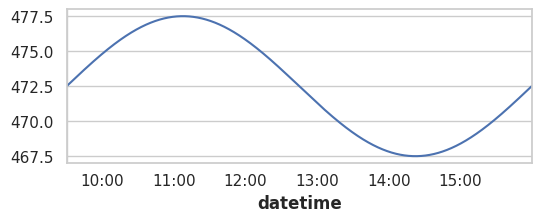

In [7]:
df = create_sinewave()
df.close.plot()

### Trend, mean reversion, or random walk
* < 0.5: Mean-reverting
* 0.5: Random walk
* \> 0.5: Trending

In [14]:
for lag in [20, 100, 250, 500, 1000]:
    hurst_exp = get_hurst_exponent(df["close"].values, lag)
    print(f"Hurst exponent with {lag} lags: {hurst_exp:.4f}")

Hurst exponent with 20 lags: 0.9998
Hurst exponent with 100 lags: 0.9993
Hurst exponent with 250 lags: 0.9984
Hurst exponent with 500 lags: 0.9967
Hurst exponent with 1000 lags: 0.9929


#### Non-Gaussian distribution of returns

<Axes: xlabel='datetime'>

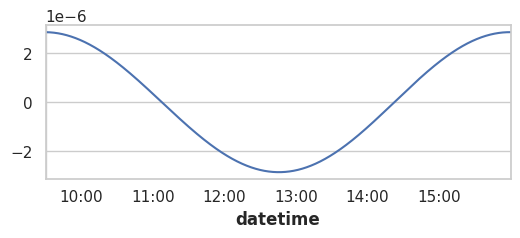

In [19]:
df['log_rtn'].plot()

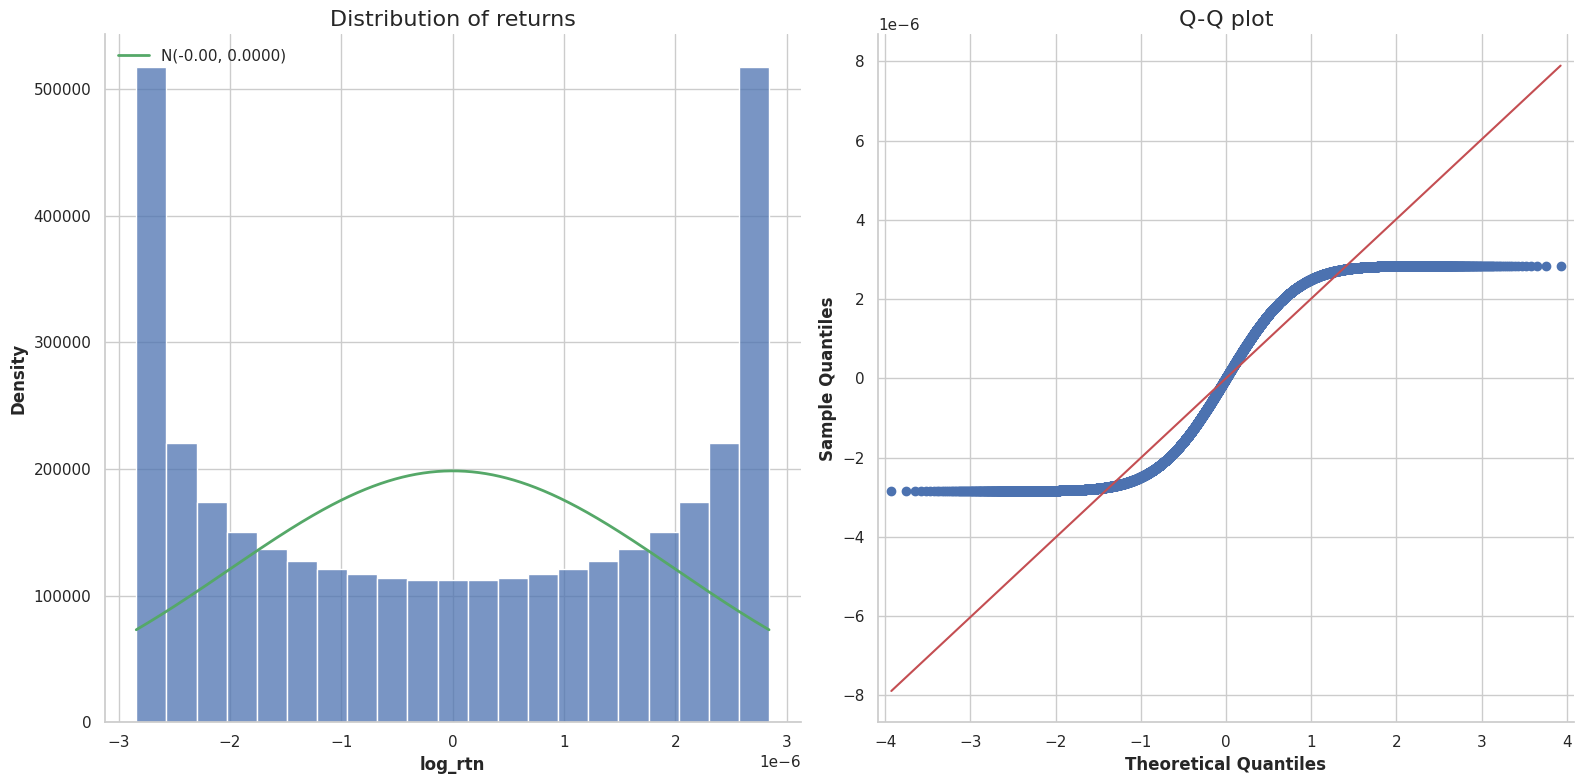

In [17]:
# Calculate the Normal PDF using the mean and standard deviation of the observed returns:
r_range = np.linspace(min(df["log_rtn"]), max(df["log_rtn"]), num=1000)
mu = df["log_rtn"].mean()
sigma = df["log_rtn"].std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma)   

# Plot the histogram and the Q-Q Plot:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# histogram
sns.histplot(df.log_rtn, kde=False, stat='density', ax=ax[0])
ax[0].set_title("Distribution of returns", fontsize=16)                                                    
ax[0].plot(r_range, norm_pdf, "g", lw=2, label=f"N({mu:.2f}, {sigma**2:.4f})")
ax[0].legend(loc="upper left");

# Q-Q plot
qq = sm.qqplot(df.log_rtn.values, line="s", ax=ax[1])
ax[1].set_title("Q-Q plot", fontsize = 16)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_11", dpi=200);

### Stationarity and Autocorrelation
Critical levels
* ADF.  1%: -3.43, 5%: -2.86, and 10%: -2.57
* KPSS. 1%: ~0.739, 5%: ~0.463, and 10%: ~0.347


Run #1: atm_quotes.close
* ADF test statistic: -38333967893 (p-val: 0.00).    < critical levels means **stationary**.
* KPSS test statistic: 19.12 (p-val: 0.01).   > critical levels means **non-stationary**.
* **Correlation at 1 and 2 intervals**

Run #2: atm_quotes.close.diff().dropna()
* ADF test statistic: -76.36 (p-val: 0.0).    < critical levels means **stationary**.
* KPSS test statistic: 6.07 (p-val: 0.01).   > critical levels means **non stationary**.
* Correlation at 1 interval

Conclusion   
Strange that ADF and KPSS give conflicting results for both diff and nondiff returns 

ADF test statistic: -76.60 (p-val: 0.00)
KPSS test statistic: 6.39 (p-val: 0.01)


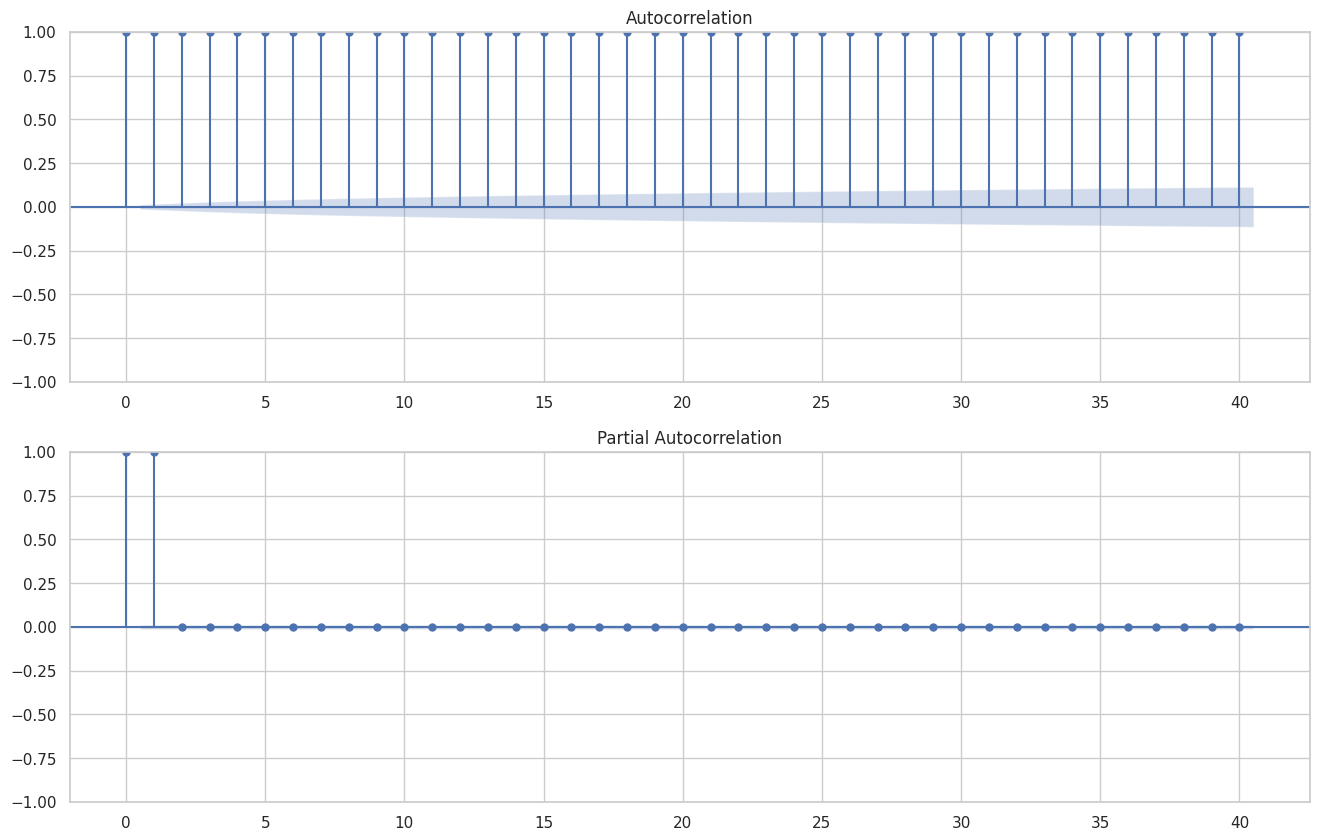

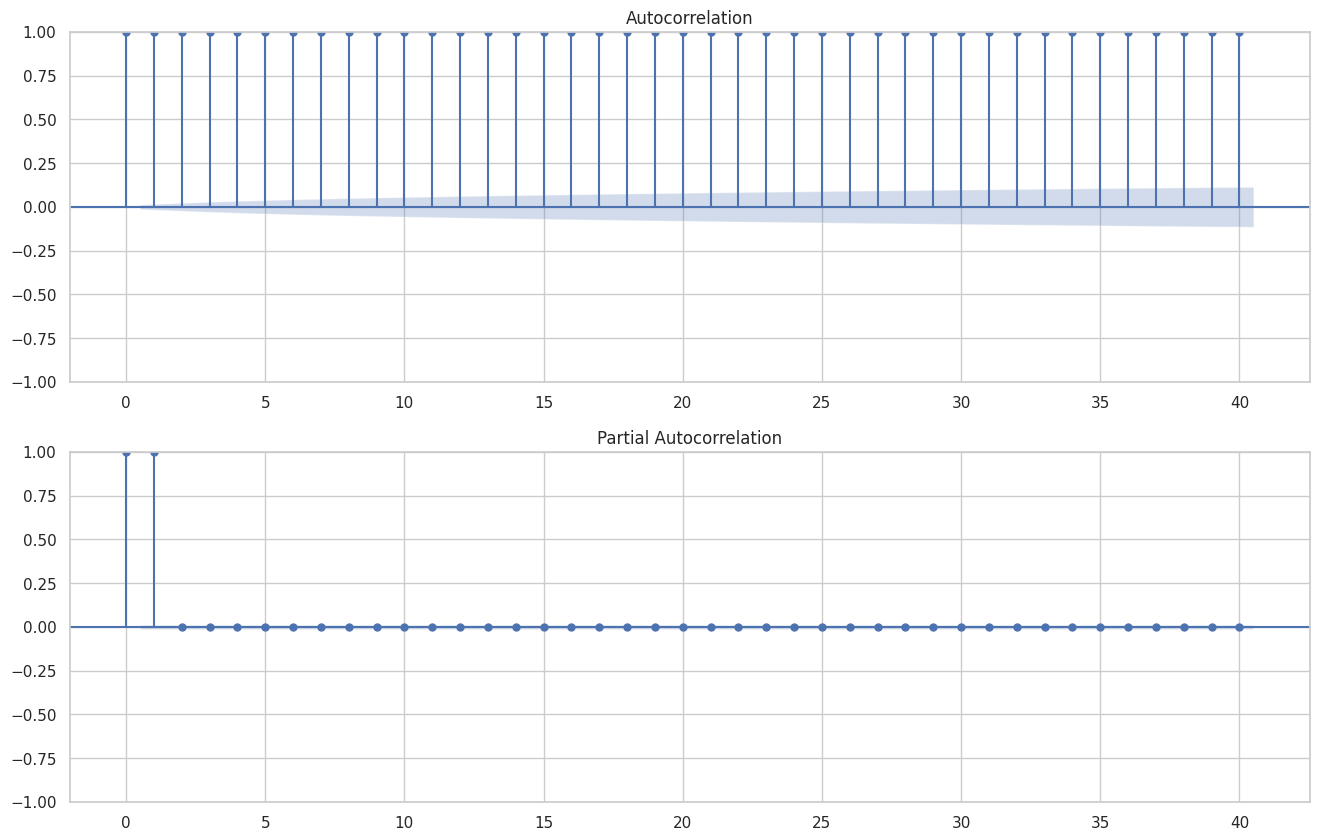

In [21]:
test_autocorrelation(df.close.diff().dropna())

#### Check seasonality

In [9]:
from darts import TimeSeries
from darts.utils.statistics import plot_acf, check_seasonality

df = create_sinewave()
series = TimeSeries.from_dataframe(df, value_cols='close')

for m in range(2, 25):
    is_seasonal, period = check_seasonality(series, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

### Absence of autocorrelation in returns

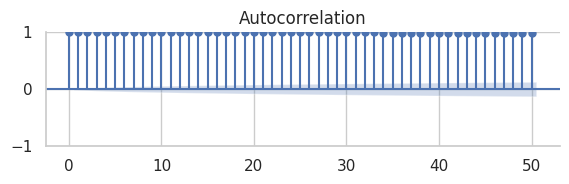

In [22]:
# Define the parameters for creating the autocorrelation plots:
N_LAGS = 50
SIGNIFICANCE_LEVEL = 0.05

# Run the following code to create ACF plot of log returns:
acf = smt.graphics.plot_acf(df["log_rtn"], lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_13", dpi=200);


### Small and decreasing autocorrelation in squared/absolute returns

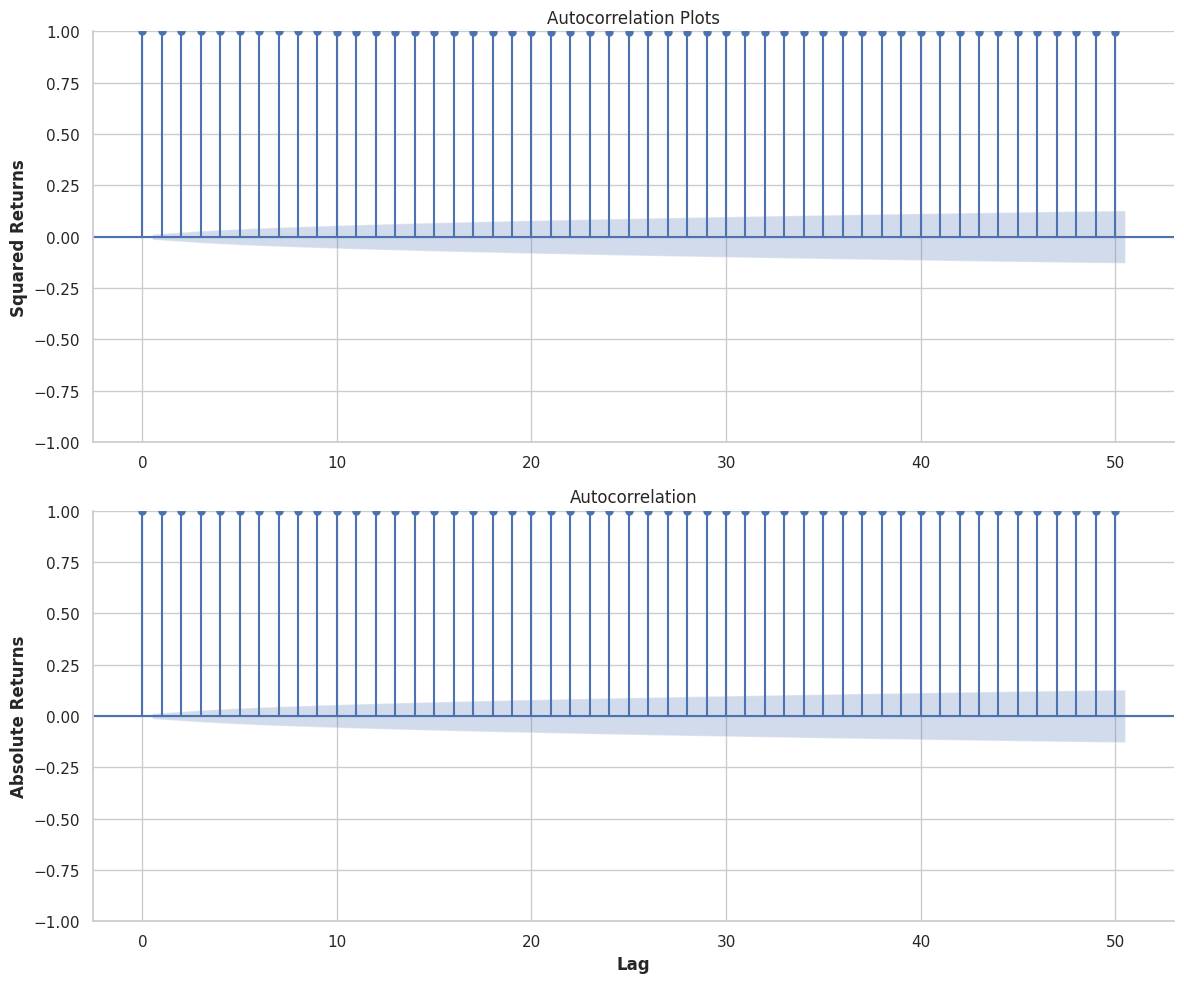

In [23]:
# Create the ACF plots:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
smt.graphics.plot_acf(df["log_rtn"]**2, lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL, ax=ax[0])
ax[0].set(title="Autocorrelation Plots", ylabel="Squared Returns")
smt.graphics.plot_acf(np.abs(df["log_rtn"]), lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL, ax=ax[1])
ax[1].set(ylabel="Absolute Returns", xlabel="Lag")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_4_14", dpi=200);

In [ ]:
#### Fact 5 - Leverage effect
# 1. Calculate volatility measures as moving standard deviations
# df["rolling_std_252"] = df[["log_rtn"]].rolling(window=252).std()
# df["rolling_std_21"] = df[["log_rtn"]].rolling(window=21).std()